In [2]:
from sortedcontainers import SortedSet
from math import sqrt
## https://stackoverflow.com/questions/8875706/heapq-with-custom-compare-predicate/8875823
# Priority Queue with custom comparator
class MyPriorityQueue(object):
    # compare1 is the function that will return f(n)-> sort in ascending order of f(n)
    # compare2 is the function that will return g(n)-> sort in ascending order of g(n) if f(n) is same
    def __init__(self, current_heuristic, target):
        self.current_heuristic = current_heuristic
#         self._data = []
        self._data = SortedSet()
        self.target = target
        self.g = dict()
        self.h = dict()
    def __len__(self):
        return len(self._data)
    #### It is required to update g(n) and h(n) before pushing the node into the priority queue
    def push(self, item):
        node = (self.calculate_priority(item), self.get_heuristic(item), item)
        self._data.add(node)
    def pop(self):
        node = self._data.pop(0)[2]
        return node
    def manhattan_distance(self, x, y): # Manhattan Distance -> heuristic = |x1-x2| + |y1-y2|
        return abs(x[0]-y[0])+abs(x[1]-y[1])
    def euclidean_distance(self, x, y): # Euclidean Distance -> heuristic = sqrt( (x1-x2)**2 + (y1-y2)**2 )
        return sqrt( (x[0]-x[1])**2 + (y[0]-y[1])**2 )
    def chebyshev_distance(self, x, y): # Chebyshev Distance -> heuristic = max(|x1-x2|, |y1-y2|)
        return max(abs(x[0]-x[1]), abs(y[0]-y[1]))
    def get_heuristic(self, x):  # returns the value of heuristic based on the heuristic function
        measure = self.current_heuristic
        if measure == 'm': # if h is manhattan
            self.h[x] = self.manhattan_distance(x, self.target)
        elif measure == 'e': # if h is euclidean
            self.h[x] = self.euclidean_distance(x, self.target)
        elif measure == 'c': # if c is chebyshev
            self.h[x] = self.chebyshev_distance(x, self.target)
        return self.h[x]
    def calculate_priority(self, x): # calculates priority for each cell - distance from cell to target
        return self.g[x] + self.get_heuristic(x)

class GridWorld:
    def __init__(self, grid, start, target, n, m, agent_grid = None ):
        self.n = n # denotes the number of rows
        self.m = m # denotes the number of columns
        self.start = start # denotes the start coordinate of the grid
        self.target = target # denotes the target coordinate of the grid
        self.trajectory = [] # denotes the trajectory of the agent in the grid
        self.grid = grid # denotes the full knowledge of the grid
        if agent_grid is None:
            self.agent_grid = np.full((n,n),'.')
        else:
            self.agent_grid = agent_grid # denotes the current knowledge of the grid
        self.sum_num_cells_processed = 0
        self.sum_bumps = 0
        self.sum_a_star = 0
        self.plan_time = 0
    def a_star(self, source, current_heuristic = 'm'):
        dirx = [-1, 1, 0, 0] ## calculates the neighbours of the current node
        diry = [0, 0, 1, -1] ## calculates the neighbours of the current node
        visited = set() ## contains the nodes that have already been added in priority queue
        closed_list = set() ## contains the nodes that have been popped from priority queue
        open_list = MyPriorityQueue(current_heuristic, self.target) ## stores the visited nodes and pops it out according to it's priority
        planned_path = [] ## Stores the path that the agent has planned according to it's current knowledge
        open_list.g[source]=0
        open_list.calculate_priority( source)
        open_list.push( source) ## This function runs in O(logn)
        visited.add(source)#visited[source] = 1
        parent = {} ## stores the parent of each node that is visited
        parent[source] = None
        while(len(open_list)>0):
            curr = open_list.pop()
            if(curr in closed_list):
                continue
            self.sum_num_cells_processed = self.sum_num_cells_processed + 1
            closed_list.add(curr)
            if(curr[0] == self.target[0] and curr[1] == self.target[1]):
                break
            for i in np.arange(4):
                childx = curr[0] + dirx[i]
                childy = curr[1] + diry[i]
                child = (childx, childy)
                if(childx>=0 and childx<m and childy>=0 and childy<n and (child not in closed_list) and self.agent_grid[childx][childy]!='X'):
                    if(child not in visited):
                        visited.add(child)
                        parent[child] = curr
                        open_list.g[child] = open_list.g[curr]+1
                        open_list.calculate_priority(child)
                        open_list.push(child)
                    else:
                        if open_list.g[curr]+1<open_list.g[child]:
                            parent[child] = curr
                            open_list._data.discard(child)
                            open_list.g[child] = open_list.g[curr]+1
                            open_list.calculate_priority(child)
                            open_list.push(child)
        if(self.target not in visited):
            return []
        curr = self.target
        while(curr != source):
            planned_path.append(curr)
            curr = parent[curr]
        planned_path.append(source)
        return planned_path[::-1]
    
    
    def check_planned_path(self, planned_path):
        dirx = [-1, 1, 0, 0]
        diry = [0, 0, -1, 1]
        n = len(planned_path)
        traversed_path = []
        for i in np.arange(n):
            currx = planned_path[i][0]
            curry = planned_path[i][1]
            if(grid[currx][curry] == 'X'):
                self.agent_grid[currx][curry] = self.grid[currx][curry]
                self.sum_bumps+=1
                break
            traversed_path.append((currx,curry))
            for i in np.arange(4):
                childx = currx + dirx[i]
                childy = curry + diry[i]
                if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                    self.agent_grid[childx][childy] = self.grid[childx][childy]
        return traversed_path
    
    ## This is the function that computes the path that repeated a-star traverses
    def compute_path(self):
        path = []
        curr = self.start
        while(curr != self.target):
            self.sum_a_star+=1
            plan_start_time = time.time()
            planned_path = self.a_star(curr)
            plan_end_time = time.time()
            self.plan_time += (plan_start_time - plan_end_time)
            if( len(planned_path) == 0 ):
                return []
            traversed_path = self.check_planned_path(planned_path)
            n = len(traversed_path)
            path.append(traversed_path)
            if(traversed_path[n-1] == self.target):
                break
            curr = traversed_path[n-1]
        return path

In [8]:
import numpy as np
p_values = np.linspace(0,0.33,34)

In [9]:
import numpy as np
# p_values = np.linspace(0,1,51)
print(p_values)
result_x = p_values

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33]


In [14]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps
import time
def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
p_values = np.round(p_values,2)
result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
avg_overall_time = []
avg_traj_len = []
avg_path_len = []
avg_plan_time = []
def update_final_discovered_grid(final_discovered_grid, rep_a_trajectory, grid):
    m = len(final_discovered_grid)
    n = len(final_discovered_grid[0])
    dirx = [-1, 1, 0, 0]
    diry = [0, 0, -1, 1]
    for x in rep_a_trajectory:
        for i in np.arange(len(x)):
            pos = x[i]
            final_discovered_grid[pos[0]][pos[1]] = grid[pos[0]][pos[1]]
            for j in np.arange(4):
                childx = pos[0] + dirx[j]
                childy = pos[1] + diry[j]
                if(childx>=0 and childx<m and childy>=0 and childy<n):
                    final_discovered_grid[childx][childy] = grid[childx][childy]
    return final_discovered_grid
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    sum_overall_time = 0
    sum_plan_time = 0
    sum_traj_len = 0
    sum_path_len = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data_Proj_2/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            while(i<m*n):
                grid.append(list(s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gw = GridWorld(grid,(0,0),(100,100),101,101)
            overall_time_start = time.time()
            ans = gw.compute_path()
            overall_time_end = time.time()
            
            final_discovered_grid = np.full((101,101),'X')
            final_discovered_grid = update_final_discovered_grid(final_discovered_grid, ans, grid)
            gw_final_discovered = GridWorld(final_discovered_grid, (0,0), (100,100), 101, 101, agent_grid = final_discovered_grid)
            shortest_path_final_discovered = gw_final_discovered.a_star((0,0),'m') #Length2
            sum_path_len = sum_path_len + len(shortest_path_final_discovered)
            
            sum_num_cells_processed += gw.sum_num_cells_processed
            sum_bumps += gw.sum_bumps
            sum_astar += gw.sum_a_star
            sum_overall_time += (overall_time_end - overall_time_start)
            sum_plan_time += gw.plan_time
            sum_traj_len += calculate_path_length(ans)
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        avg_overall_time.append(sum_overall_time/250)
        avg_plan_time.append(sum_plan_time/250)
        avg_traj_len.append(sum_traj_len/250)
        avg_path_len.append(sum_path_len/250)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 31/34 [11:49<01:08, 22.90s/it]


KeyboardInterrupt: 

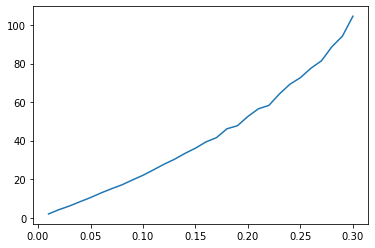

In [39]:
import matplotlib.pyplot as plt
plt.plot(result_x[:],avg_bumps)

In [34]:
# import pickle
# with open('agent_1_avg_bumps.pkl', 'wb') as f:
#     pickle.dump(avg_bumps, f)

In [2]:
import pickle
with open('agent_2_avg_bumps.pkl', 'rb') as f:
    agent_2_avg_bumps = pickle.load(f)

In [3]:
agent_2_avg_bumps

[1.992,
 4.292,
 6.248,
 8.676,
 10.984,
 13.624,
 16.04,
 18.568,
 21.416,
 24.376,
 27.98,
 31.704,
 34.744,
 38.712,
 42.48,
 46.876,
 49.88,
 56.076,
 58.552,
 65.38,
 71.392,
 74.76,
 83.004,
 91.536,
 95.932,
 104.652,
 111.208,
 121.808,
 131.672,
 147.108]

In [ ]:
x